In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback

os.environ["WANDB_SILENT"] = "true"

#### Logistic Regression: Formula Label Prediction (Variant 1: Stream of math tokens)

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

#from tf.keras.callbacks import tensorboard_callback

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tmp/tfdbg2_logdir")
"""
tf.debugging.experimental.enable_dump_debug_info(
    "./tmp/tfdbg2_logdir",
    tensor_debug_mode="FULL_HEALTH",
    circular_buffer_size=-1)
"""

'\ntf.debugging.experimental.enable_dump_debug_info(\n    "./tmp/tfdbg2_logdir",\n    tensor_debug_mode="FULL_HEALTH",\n    circular_buffer_size=-1)\n'

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [6]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [7]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,tokens,type_tokens,label
0,f : A \to B,"['func_def', 'func_name', '__ANON_1', 'COLON',...",1
1,f,"['func_name', '__ANON_1']",1
2,g \colon B \to I,"['func_def', 'func_name', '__ANON_1', 'COLON',...",1
3,\frac { 8 ! } { ( 8 - 4 ) ! },"['expr_atom', 'CMD_FRAC', 'L_BRACE', 'postfix'...",1
4,f,"['func_name', '__ANON_1']",1


In [8]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"], data["label"])) 
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

##### Setup and Data Preparation

In [9]:
for example, label in train_dataset.take(3):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'f'
label:  1
text:  b'f'
label:  1
text:  b'f : X \\rightarrow Y'
label:  1


In [10]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [11]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [12]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


array(['', '[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U2

In [13]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)
print(label.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[ 2  8 23 26 29]
(5,)
()


In [14]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'f : X \\rightarrow Y'
After reverse lookup:  f : X \rightarrow Y


##### Representation 2: Binary Count Vectorizer

In [15]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'V', 'H',
       'j', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\exp',
       '\\sin', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [16]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(122,)


##### Representation 3: Frequency Count Vectorizer

In [17]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'F', 'c', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [18]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(122,)


##### Representation 4: Bigrams Frequency Count Vectorizer

In [19]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', 'f :', '+', '3', 'A', '-', 'g', 'n', '( x', 'B', '4',
       'f (', 'x )', 'a', 'X', '=', ') =', '5', '\\rightarrow', '^ 2',
       '} {', 'b', ': A', '6', 'Y', '7', '\\frac {', '\\frac', '\\mathbb',
       '9', '- 1', 'A \\to', ': X', '\\mathbb{N}', '1 }', 'x ^',
       '\\mathbb{R}', '+ 1', 'h', '^ {', '1 0', '{ 1', '\\to B', '0 0',
       '8', 'X \\to', 'y', 'R', '\\colon', 'g :', '\\to Y', 'N', '0 1',
       'S', 'c', '2 }', 'F', '1 )', '\\times', 'x +', '{ x', '{ 2', 'p',
       '2 ^', 'k', '\\mathbb R', 'f \\colon', 'm', '( n', '2 +', '/',
       '1 2', '\\mathbb N', '{ a', 'x -', 'C', ': \\mathbb{N}', '= x',
       'n )', 'A \\rightarrow', 'a b', '\\to A', 'n +', ': \\mathbb{R}',
       't', 'i', 'X \\rightarrow', '1 1', 'x }', '^ n', ': \\mathbb',
       '\\to \\mathbb{R}', 'd', '\\to \\mathbb', '3 }',
       '\\mathbb{N} \\to', '\\rightarrow B', '2 0', 'z', '^ 3', 'e',
       '= \\frac', 's',

In [20]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Representation 5: Tf-Idf Vectorizer

In [21]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'S',
       'N', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '\\circ', 'P', '!', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'H',
       'V', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [22]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0.        1.3786807 0.        0.        0.        0.        0.
 2.0542634 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        3.0622458 0.        0.        3.077943  0.        0.
 3.3447478 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.  

##### Model (Logistic Regression)

 **Define and compile model**

In [23]:
"""
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(encoder_int)
embedding = tf.keras.layers.Embedding(
                input_dim=len(encoder_int.get_vocabulary()),
                output_dim=64,
                # user masking to handle the variable sequence lengths
                mask_zero=True)
model.add(embedding)
model.output_shape
"""

'\nmodel = tf.keras.Sequential()\nmodel.add(tf.keras.Input(shape=(1,), dtype=tf.string))\nmodel.add(encoder_int)\nembedding = tf.keras.layers.Embedding(\n                input_dim=len(encoder_int.get_vocabulary()),\n                output_dim=64,\n                # user masking to handle the variable sequence lengths\n                mask_zero=True)\nmodel.add(embedding)\nmodel.output_shape\n'

In [24]:
def create_model(vec_encoder):
    print(len(vec_encoder.get_vocabulary()))
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=len(vec_encoder.get_vocabulary()),
            output_dim=16,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [25]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [26]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

123
1/1 [==============================] - 0s 85ms/step
[0.04357712]


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          1968      
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [28]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])


In [29]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
117/156 [=====================>........] - ETA: 0s - loss: 0.6660 - accuracy: 0.5467INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6577 - accuracy: 0.5551 - val_loss: 0.6514 - val_accuracy: 0.0000e+00
Epoch 2/200
131/156 [========================>.....] - ETA: 0s - loss: 0.5922 - accuracy: 0.6380INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.5859 - accuracy: 0.6482 - val_loss: 0.5862 - val_accuracy: 0.3490
Epoch 3/200
134/156 [========================>.....] - ETA: 0s - loss: 0.5369 - accuracy: 0.6876INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.5337 - accuracy: 0.6910 - val_loss: 0.5475 - val_accuracy: 0.3885
Epoch 4/200
124/156 [======================>.......] - ETA: 0s - loss: 0.5047 - accuracy: 0.7107INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.5051 - accuracy: 0.7094 - val_loss: 0.5261 - val_accuracy: 0.4823
Epoch 5/200
147/156 [===========================>..] - ETA: 0s - loss: 0.4900 - accuracy: 0.7283INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.4906 - accuracy: 0.7281 - val_loss: 0.5051 - val_accuracy: 0.7417
Epoch 6/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4836 - accuracy: 0.7382 - val_loss: 0.5086 - val_accuracy: 0.7490
Epoch 7/200
156/156 [==============================] - 0s 1ms/step - loss: 0.4764 - accuracy: 0.7458 - val_loss: 0.5067 - val_accuracy: 0.7573
Epoch 8/200
151/156 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.7437INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.4741 - accuracy: 0.7448 - val_loss: 0.4990 - val_accuracy: 0.7635
Epoch 9/200
146/156 [===========================>..] - ETA: 0s - loss: 0.4722 - accuracy: 0.7459INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.4726 - accuracy: 0.7442 - val_loss: 0.4956 - val_accuracy: 0.7656
Epoch 10/200
146/156 [===========================>..] - ETA: 0s - loss: 0.4672 - accuracy: 0.7528INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.4694 - accuracy: 0.7506 - val_loss: 0.4924 - val_accuracy: 0.7667
Epoch 11/200
143/156 [==========================>...] - ETA: 0s - loss: 0.4658 - accuracy: 0.7533INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.4661 - accuracy: 0.7540 - val_loss: 0.4872 - val_accuracy: 0.7667
Epoch 12/200
152/156 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.7562INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110826-43iaxrhz/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.4665 - accuracy: 0.7560 - val_loss: 0.4825 - val_accuracy: 0.7781
Epoch 13/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4633 - accuracy: 0.7553 - val_loss: 0.4862 - val_accuracy: 0.7812
Epoch 14/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7584 - val_loss: 0.5004 - val_accuracy: 0.7740
Epoch 15/200
156/156 [==============================] - 0s 1ms/step - loss: 0.4602 - accuracy: 0.7590 - val_loss: 0.5153 - val_accuracy: 0.7646
Epoch 16/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4618 - accuracy: 0.7549 - val_loss: 0.5050 - val_accuracy: 0.7750
Epoch 17/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4586 - accuracy: 0.7612 - val_loss: 0.5104 - val_accuracy: 0.7729
Epoch 18/200
156/156 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7591 - val_loss: 0.5045 - val_accuracy: 0.7781
Epoch

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 788us/step - loss: 0.5139 - accuracy: 0.8031
Test Loss: 0.5139275193214417
Test Accuracy: 0.8031250238418579


(0.0, 0.6683848619461059)

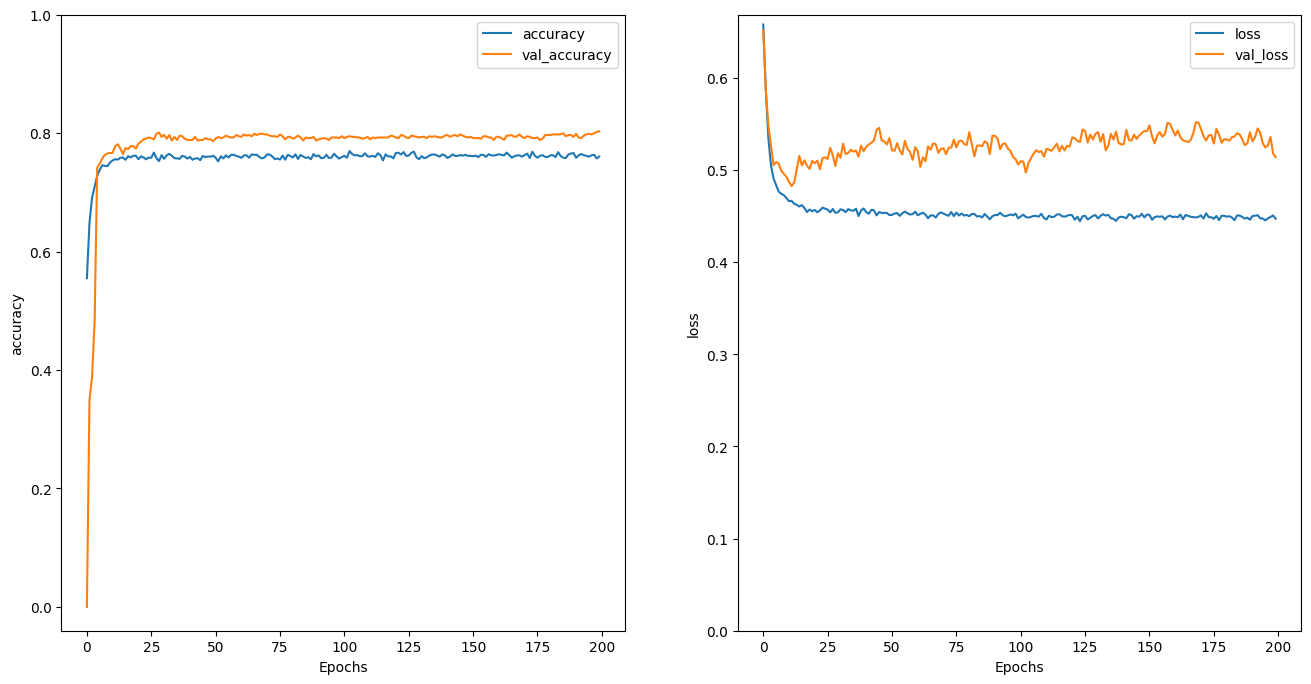

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [32]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 78ms/step
[-1.2727685]


##### Experiment 2: Use binary count vectorizer for encoding

In [33]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

122
1/1 [==============================] - 0s 73ms/step
[-0.0162912]


In [34]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [35]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
145/156 [==========================>...] - ETA: 0s - loss: 0.6891 - accuracy: 0.5491INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6888 - accuracy: 0.5501 - val_loss: 0.8222 - val_accuracy: 0.0000e+00
Epoch 2/200
145/156 [==========================>...] - ETA: 0s - loss: 0.6888 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6888 - accuracy: 0.5497 - val_loss: 0.7814 - val_accuracy: 0.0000e+00
Epoch 3/200
144/156 [==========================>...] - ETA: 0s - loss: 0.6880 - accuracy: 0.5497INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5501 - val_loss: 0.7701 - val_accuracy: 0.0000e+00
Epoch 4/200
142/156 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.5489INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_110952-57zadoyg/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6883 - accuracy: 0.5498 - val_loss: 0.7557 - val_accuracy: 0.0000e+00
Epoch 5/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5499 - val_loss: 0.7885 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5498 - val_loss: 0.8283 - val_accuracy: 0.0000e+00
Epoch 7/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5503 - val_loss: 0.8130 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5499 - val_loss: 0.8109 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5498 - val_loss: 0.7905 - val_accuracy: 0.0000e+00
Epoch 10/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5498 - val_loss: 0.8273 - val_acc

In [36]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 1ms/step - loss: 0.7792 - accuracy: 0.0000e+00
Test Loss: 0.7791679501533508
Test Accuracy: 0.0


(0.0, 0.856545701622963)

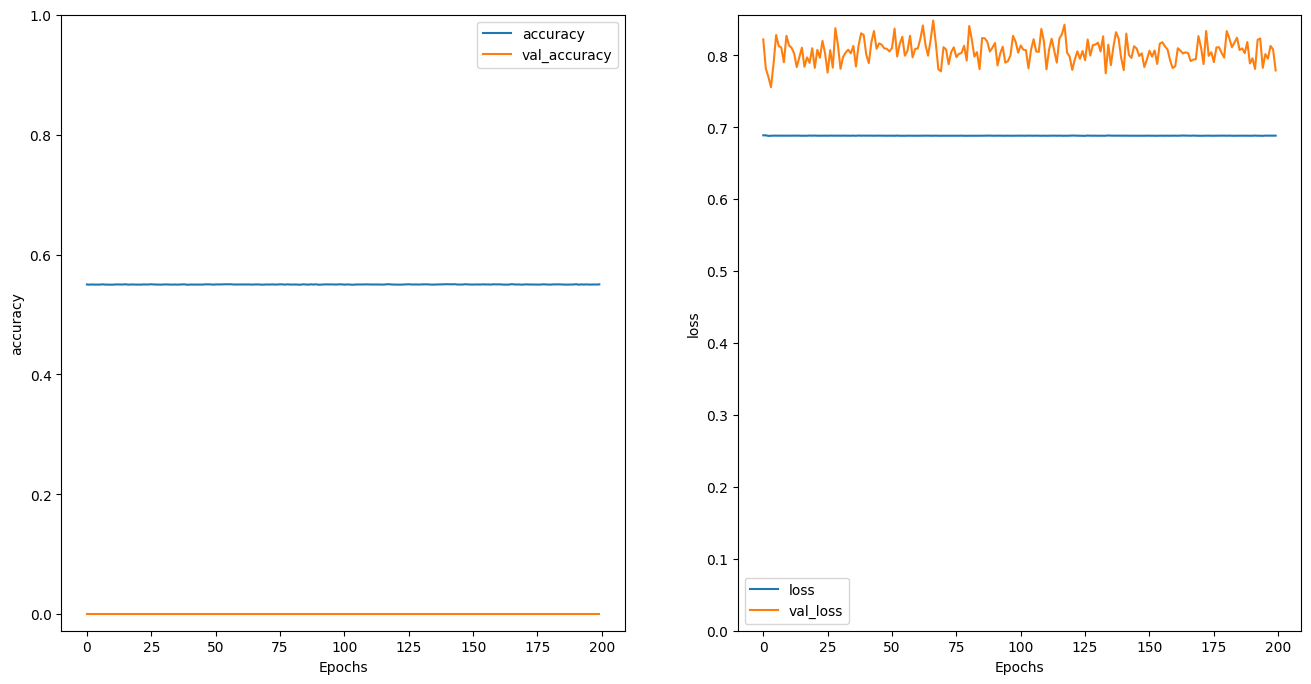

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [38]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 89ms/step
[-0.1652383]


##### Experiment 3:

In [39]:
model = create_model(encoder_count)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

122


1/1 [==============================] - 0s 68ms/step
[-0.01334807]


In [40]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [41]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])


run.finish()

Epoch 1/200
137/156 [=========================>....] - ETA: 0s - loss: 0.6724 - accuracy: 0.5512INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 2s 12ms/step - loss: 0.6735 - accuracy: 0.5502 - val_loss: 0.7234 - val_accuracy: 0.0000e+00
Epoch 2/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5496 - val_loss: 0.7271 - val_accuracy: 0.0000e+00
Epoch 3/200
143/156 [==========================>...] - ETA: 0s - loss: 0.6691 - accuracy: 0.5479INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6686 - accuracy: 0.5497 - val_loss: 0.6966 - val_accuracy: 0.0000e+00
Epoch 4/200
154/156 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6685 - accuracy: 0.5502 - val_loss: 0.6949 - val_accuracy: 0.0000e+00
Epoch 5/200
148/156 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.5511INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6695 - accuracy: 0.5497 - val_loss: 0.6896 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5505 - val_loss: 0.7017 - val_accuracy: 0.0000e+00
Epoch 7/200
140/156 [=========================>....] - ETA: 0s - loss: 0.6684 - accuracy: 0.5518INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6690 - accuracy: 0.5498 - val_loss: 0.6790 - val_accuracy: 0.0000e+00
Epoch 8/200
154/156 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.5495INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6676 - accuracy: 0.5499 - val_loss: 0.6606 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.5500 - val_loss: 0.7235 - val_accuracy: 0.0000e+00
Epoch 10/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6687 - accuracy: 0.5501 - val_loss: 0.6976 - val_accuracy: 0.0000e+00
Epoch 11/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6675 - accuracy: 0.5501 - val_loss: 0.7121 - val_accuracy: 0.0000e+00
Epoch 12/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.5501 - val_loss: 0.7440 - val_accuracy: 0.0000e+00
Epoch 13/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5501 - val_loss: 0.7125 - val_accuracy: 0.0000e+00
Epoch 14/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6680 - accuracy: 0.5498 - val_loss: 0.7373 - val

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6684 - accuracy: 0.5497 - val_loss: 0.6525 - val_accuracy: 0.0000e+00
Epoch 20/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5496 - val_loss: 0.7173 - val_accuracy: 0.0000e+00
Epoch 21/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5503 - val_loss: 0.6989 - val_accuracy: 0.0000e+00
Epoch 22/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5500 - val_loss: 0.6827 - val_accuracy: 0.0000e+00
Epoch 23/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5503 - val_loss: 0.7094 - val_accuracy: 0.0000e+00
Epoch 24/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5500 - val_loss: 0.7060 - val_accuracy: 0.0000e+00
Epoch 25/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5502 - val_loss: 0.6742 - v

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6685 - accuracy: 0.5504 - val_loss: 0.6461 - val_accuracy: 0.0000e+00
Epoch 56/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6672 - accuracy: 0.5503 - val_loss: 0.7051 - val_accuracy: 0.0000e+00
Epoch 57/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6687 - accuracy: 0.5495 - val_loss: 0.7125 - val_accuracy: 0.0000e+00
Epoch 58/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.5501 - val_loss: 0.6777 - val_accuracy: 0.0000e+00
Epoch 59/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6683 - accuracy: 0.5503 - val_loss: 0.6810 - val_accuracy: 0.0000e+00
Epoch 60/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6680 - accuracy: 0.5497 - val_loss: 0.6854 - val_accuracy: 0.0000e+00
Epoch 61/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5500 - val_loss: 0.6708 - va

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6673 - accuracy: 0.5498 - val_loss: 0.6438 - val_accuracy: 0.0000e+00
Epoch 112/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.5503 - val_loss: 0.6558 - val_accuracy: 0.0000e+00
Epoch 113/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.5502 - val_loss: 0.7030 - val_accuracy: 0.0000e+00
Epoch 114/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6688 - accuracy: 0.5499 - val_loss: 0.6780 - val_accuracy: 0.0000e+00
Epoch 115/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5503 - val_loss: 0.6636 - val_accuracy: 0.0000e+00
Epoch 116/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.5503 - val_loss: 0.6617 - val_accuracy: 0.0000e+00
Epoch 117/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6681 - accuracy: 0.5501 - val_loss: 0.673

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6678 - accuracy: 0.5502 - val_loss: 0.6436 - val_accuracy: 0.0000e+00
Epoch 138/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6688 - accuracy: 0.5501 - val_loss: 0.6742 - val_accuracy: 0.0000e+00
Epoch 139/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.5501 - val_loss: 0.6910 - val_accuracy: 0.0000e+00
Epoch 140/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.5504 - val_loss: 0.6882 - val_accuracy: 0.0000e+00
Epoch 141/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6680 - accuracy: 0.5498 - val_loss: 0.6599 - val_accuracy: 0.0000e+00
Epoch 142/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6687 - accuracy: 0.5500 - val_loss: 0.6768 - val_accuracy: 0.0000e+00
Epoch 143/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.5498 - val_loss: 0.662

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6677 - accuracy: 0.5503 - val_loss: 0.6414 - val_accuracy: 0.0000e+00
Epoch 177/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6684 - accuracy: 0.5496 - val_loss: 0.6833 - val_accuracy: 0.0000e+00
Epoch 178/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.5501 - val_loss: 0.6724 - val_accuracy: 0.0000e+00
Epoch 179/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.5499 - val_loss: 0.6786 - val_accuracy: 0.0000e+00
Epoch 180/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.5498 - val_loss: 0.6708 - val_accuracy: 0.0000e+00
Epoch 181/200
139/156 [=========================>....] - ETA: 0s - loss: 0.6688 - accuracy: 0.5523INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6687 - accuracy: 0.5500 - val_loss: 0.6408 - val_accuracy: 0.0000e+00
Epoch 182/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6679 - accuracy: 0.5503 - val_loss: 0.6800 - val_accuracy: 0.0000e+00
Epoch 183/200
141/156 [==========================>...] - ETA: 0s - loss: 0.6672 - accuracy: 0.5515INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111144-nxgccegc/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6676 - accuracy: 0.5502 - val_loss: 0.6266 - val_accuracy: 0.0000e+00
Epoch 184/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5500 - val_loss: 0.6789 - val_accuracy: 0.0000e+00
Epoch 185/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.5500 - val_loss: 0.6747 - val_accuracy: 0.0000e+00
Epoch 186/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.5498 - val_loss: 0.6691 - val_accuracy: 0.0000e+00
Epoch 187/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6675 - accuracy: 0.5500 - val_loss: 0.6643 - val_accuracy: 0.0000e+00
Epoch 188/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.5500 - val_loss: 0.6597 - val_accuracy: 0.0000e+00
Epoch 189/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6681 - accuracy: 0.5502 - val_loss: 0.65

In [42]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 937us/step - loss: 0.7010 - accuracy: 0.0000e+00
Test Loss: 0.7009772658348083
Test Accuracy: 0.0


(0.0, 0.749822410941124)

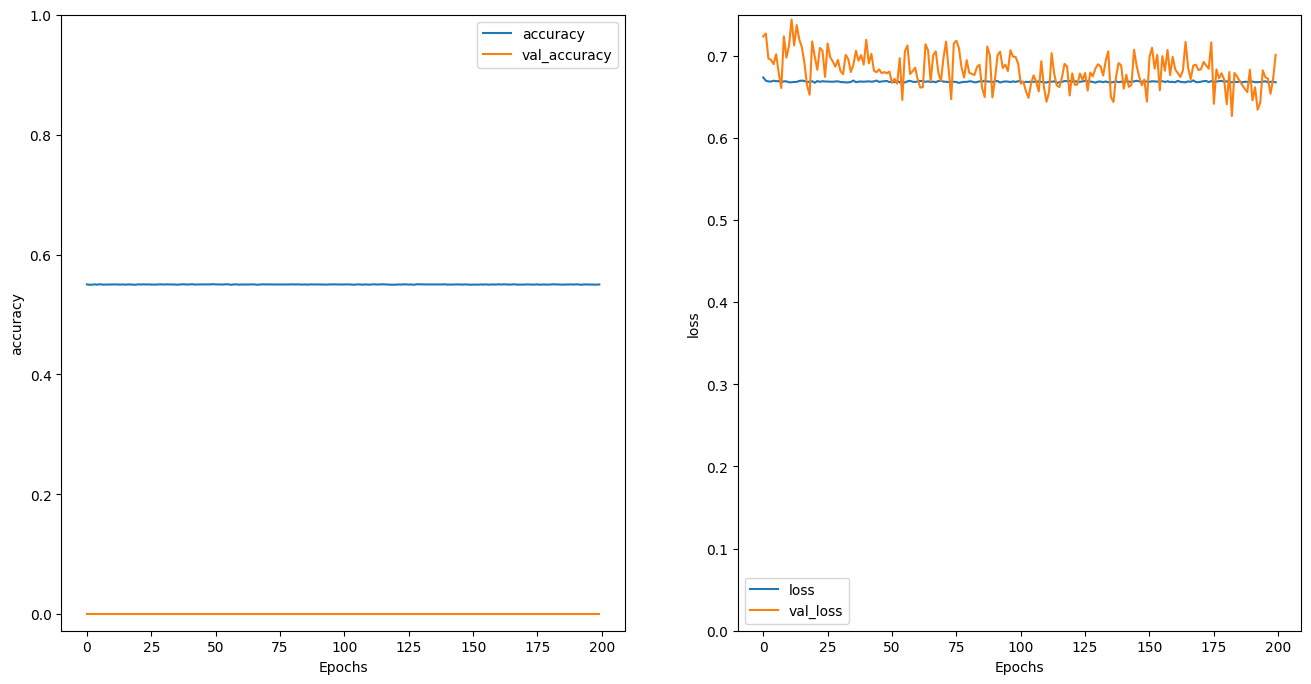

In [43]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [44]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 77ms/step
[-0.6168145]


##### Experiment 4:

In [45]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1000
1/1 [==============================] - 0s 75ms/step
[-0.00362216]


In [46]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [47]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])

run.finish()

Epoch 1/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6756 - accuracy: 0.5482INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 3s 15ms/step - loss: 0.6754 - accuracy: 0.5499 - val_loss: 0.7377 - val_accuracy: 0.0000e+00
Epoch 2/200
153/156 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 15ms/step - loss: 0.6701 - accuracy: 0.5501 - val_loss: 0.7290 - val_accuracy: 0.0000e+00
Epoch 3/200
153/156 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.5495INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 14ms/step - loss: 0.6709 - accuracy: 0.5497 - val_loss: 0.7284 - val_accuracy: 0.0000e+00
Epoch 4/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6720 - accuracy: 0.5490INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.6716 - accuracy: 0.5500 - val_loss: 0.7099 - val_accuracy: 0.0000e+00
Epoch 5/200
156/156 [==============================] - 2s 10ms/step - loss: 0.6715 - accuracy: 0.5494 - val_loss: 0.7290 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 2s 10ms/step - loss: 0.6703 - accuracy: 0.5500 - val_loss: 0.7365 - val_accuracy: 0.0000e+00
Epoch 7/200
155/156 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.5496INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 14ms/step - loss: 0.6701 - accuracy: 0.5498 - val_loss: 0.7096 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6709 - accuracy: 0.5499 - val_loss: 0.7359 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6692 - accuracy: 0.5501 - val_loss: 0.7299 - val_accuracy: 0.0000e+00
Epoch 10/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6710 - accuracy: 0.5504 - val_loss: 0.7174 - val_accuracy: 0.0000e+00
Epoch 11/200
156/156 [==============================] - 2s 9ms/step - loss: 0.6691 - accuracy: 0.5501 - val_loss: 0.7469 - val_accuracy: 0.0000e+00
Epoch 12/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6701 - accuracy: 0.5500 - val_loss: 0.7200 - val_accuracy: 0.0000e+00
Epoch 13/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6719 - accuracy: 0.5503 - val_loss: 0.7227 - val

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 15ms/step - loss: 0.6711 - accuracy: 0.5500 - val_loss: 0.6994 - val_accuracy: 0.0000e+00
Epoch 15/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6706 - accuracy: 0.5499 - val_loss: 0.7158 - val_accuracy: 0.0000e+00
Epoch 16/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6693 - accuracy: 0.5499 - val_loss: 0.7119 - val_accuracy: 0.0000e+00
Epoch 17/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6691 - accuracy: 0.5501 - val_loss: 0.7157 - val_accuracy: 0.0000e+00
Epoch 18/200
153/156 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.5508INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 15ms/step - loss: 0.6693 - accuracy: 0.5500 - val_loss: 0.6964 - val_accuracy: 0.0000e+00
Epoch 19/200
156/156 [==============================] - 2s 10ms/step - loss: 0.6704 - accuracy: 0.5499 - val_loss: 0.7099 - val_accuracy: 0.0000e+00
Epoch 20/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6699 - accuracy: 0.5500 - val_loss: 0.7129 - val_accuracy: 0.0000e+00
Epoch 21/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6693 - accuracy: 0.5498 - val_loss: 0.7168 - val_accuracy: 0.0000e+00
Epoch 22/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6691 - accuracy: 0.5502 - val_loss: 0.7005 - val_accuracy: 0.0000e+00
Epoch 23/200
156/156 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 14ms/step - loss: 0.6696 - accuracy: 0.5500 - val_loss: 0.6866 - val_accuracy: 0.0000e+00
Epoch 24/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6705 - accuracy: 0.5498 - val_loss: 0.7329 - val_accuracy: 0.0000e+00
Epoch 25/200
156/156 [==============================] - 2s 9ms/step - loss: 0.6700 - accuracy: 0.5502 - val_loss: 0.7060 - val_accuracy: 0.0000e+00
Epoch 26/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6702 - accuracy: 0.5496 - val_loss: 0.7138 - val_accuracy: 0.0000e+00
Epoch 27/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6705 - accuracy: 0.5503 - val_loss: 0.6980 - val_accuracy: 0.0000e+00
Epoch 28/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6680 - accuracy: 0.5501 - val_loss: 0.7229 - val_accuracy: 0.0000e+00
Epoch 29/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6703 - accuracy: 0.5501 - val_loss: 0.6986 - v

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 14ms/step - loss: 0.6702 - accuracy: 0.5499 - val_loss: 0.6855 - val_accuracy: 0.0000e+00
Epoch 32/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6708 - accuracy: 0.5498 - val_loss: 0.7036 - val_accuracy: 0.0000e+00
Epoch 33/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6690 - accuracy: 0.5500 - val_loss: 0.7028 - val_accuracy: 0.0000e+00
Epoch 34/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6710 - accuracy: 0.5500 - val_loss: 0.6940 - val_accuracy: 0.0000e+00
Epoch 35/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6703 - accuracy: 0.5501 - val_loss: 0.6861 - val_accuracy: 0.0000e+00
Epoch 36/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6709 - accuracy: 0.5500 - val_loss: 0.7005 - val_accuracy: 0.0000e+00
Epoch 37/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6719 - accuracy: 0.5500 - val_loss: 0.7132 - v

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.6703 - accuracy: 0.5501 - val_loss: 0.6738 - val_accuracy: 0.0000e+00
Epoch 45/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6705 - accuracy: 0.5502 - val_loss: 0.7031 - val_accuracy: 0.0000e+00
Epoch 46/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6714 - accuracy: 0.5498 - val_loss: 0.6858 - val_accuracy: 0.0000e+00
Epoch 47/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6712 - accuracy: 0.5498 - val_loss: 0.6863 - val_accuracy: 0.0000e+00
Epoch 48/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6707 - accuracy: 0.5502 - val_loss: 0.6896 - val_accuracy: 0.0000e+00
Epoch 49/200
154/156 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6696 - accuracy: 0.5501 - val_loss: 0.6637 - val_accuracy: 0.0000e+00
Epoch 50/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6700 - accuracy: 0.5499 - val_loss: 0.6838 - val_accuracy: 0.0000e+00
Epoch 51/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6699 - accuracy: 0.5500 - val_loss: 0.6882 - val_accuracy: 0.0000e+00
Epoch 52/200
156/156 [==============================] - 2s 10ms/step - loss: 0.6705 - accuracy: 0.5499 - val_loss: 0.7101 - val_accuracy: 0.0000e+00
Epoch 53/200
156/156 [==============================] - 2s 11ms/step - loss: 0.6709 - accuracy: 0.5500 - val_loss: 0.7108 - val_accuracy: 0.0000e+00
Epoch 54/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6693 - accuracy: 0.5500 - val_loss: 0.6837 - val_accuracy: 0.0000e+00
Epoch 55/200
156/156 [==============================] - 2s 11ms/step - loss: 0.6709 - accuracy: 0.5501 - val_loss: 0.7233 

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 14ms/step - loss: 0.6709 - accuracy: 0.5503 - val_loss: 0.6463 - val_accuracy: 0.0000e+00
Epoch 78/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6705 - accuracy: 0.5500 - val_loss: 0.6554 - val_accuracy: 0.0000e+00
Epoch 79/200
156/156 [==============================] - 2s 9ms/step - loss: 0.6701 - accuracy: 0.5501 - val_loss: 0.7007 - val_accuracy: 0.0000e+00
Epoch 80/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6712 - accuracy: 0.5498 - val_loss: 0.7225 - val_accuracy: 0.0000e+00
Epoch 81/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6714 - accuracy: 0.5502 - val_loss: 0.7033 - val_accuracy: 0.0000e+00
Epoch 82/200
156/156 [==============================] - 2s 12ms/step - loss: 0.6704 - accuracy: 0.5499 - val_loss: 0.6953 - val_accuracy: 0.0000e+00
Epoch 83/200
156/156 [==============================] - 2s 12ms/step - loss: 0.6700 - accuracy: 0.5500 - val_loss: 0.7028 -

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111341-ilclsn0h/files/model-best/assets


156/156 [==============================] - 2s 15ms/step - loss: 0.6703 - accuracy: 0.5499 - val_loss: 0.6323 - val_accuracy: 0.0000e+00
Epoch 157/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6715 - accuracy: 0.5502 - val_loss: 0.6554 - val_accuracy: 0.0000e+00
Epoch 158/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6719 - accuracy: 0.5501 - val_loss: 0.6914 - val_accuracy: 0.0000e+00
Epoch 159/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6712 - accuracy: 0.5499 - val_loss: 0.6605 - val_accuracy: 0.0000e+00
Epoch 160/200
156/156 [==============================] - 2s 10ms/step - loss: 0.6700 - accuracy: 0.5498 - val_loss: 0.6948 - val_accuracy: 0.0000e+00
Epoch 161/200
156/156 [==============================] - 2s 10ms/step - loss: 0.6700 - accuracy: 0.5501 - val_loss: 0.6641 - val_accuracy: 0.0000e+00
Epoch 162/200
156/156 [==============================] - 2s 12ms/step - loss: 0.6705 - accuracy: 0.5500 - val_loss: 0

In [48]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.0000e+00
Test Loss: 0.6683318614959717
Test Accuracy: 0.0


(0.0, 0.752591472864151)

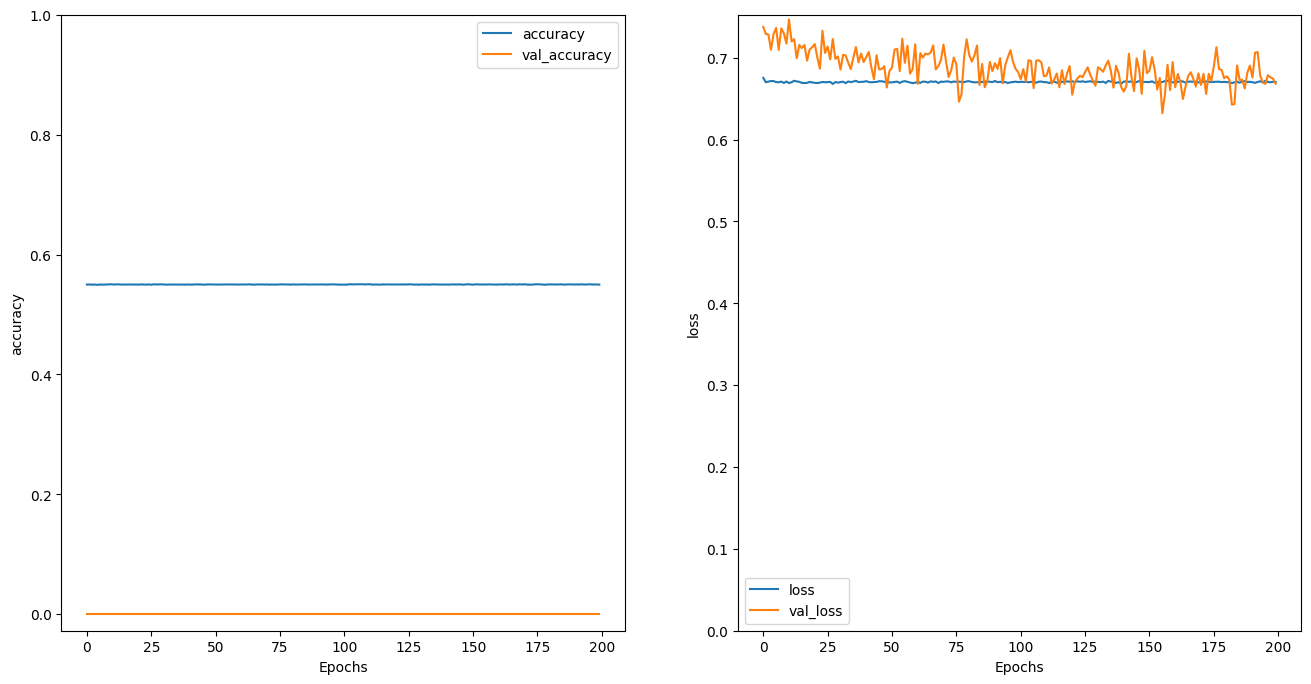

In [49]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [50]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 75ms/step
[-0.43868077]


##### Experiment 5:

In [51]:
model = create_model(encoder_tf_idf)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

122
1/1 [==============================] - 0s 72ms/step
[-0.02859315]


In [52]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [53]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])

run.finish()

Epoch 1/200
137/156 [=========================>....] - ETA: 0s - loss: 0.6800 - accuracy: 0.5528INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111907-a9vhjqfk/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111907-a9vhjqfk/files/model-best/assets


156/156 [==============================] - 3s 13ms/step - loss: 0.6811 - accuracy: 0.5501 - val_loss: 0.7385 - val_accuracy: 0.0000e+00
Epoch 2/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5505 - val_loss: 0.7880 - val_accuracy: 0.0000e+00
Epoch 3/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.5506 - val_loss: 0.7624 - val_accuracy: 0.0010
Epoch 4/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6760 - accuracy: 0.5515 - val_loss: 0.8267 - val_accuracy: 0.0010
Epoch 5/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.5512 - val_loss: 0.7926 - val_accuracy: 0.0010
Epoch 6/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6751 - accuracy: 0.5520 - val_loss: 0.8052 - val_accuracy: 0.0010
Epoch 7/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6745 - accuracy: 0.5498 - val_loss: 0.7586 - val_accuracy: 0.0031
Ep

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111907-a9vhjqfk/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6746 - accuracy: 0.5513 - val_loss: 0.7358 - val_accuracy: 0.0052
Epoch 16/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.5504 - val_loss: 0.7743 - val_accuracy: 0.0031
Epoch 17/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6747 - accuracy: 0.5513 - val_loss: 0.7734 - val_accuracy: 0.0010
Epoch 18/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6747 - accuracy: 0.5516 - val_loss: 0.7804 - val_accuracy: 0.0010
Epoch 19/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.5507 - val_loss: 0.7670 - val_accuracy: 0.0010
Epoch 20/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.5508 - val_loss: 0.7824 - val_accuracy: 0.0010
Epoch 21/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5515 - val_loss: 0.7619 - val_accuracy: 0.0010
Epoch

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111907-a9vhjqfk/files/model-best/assets


156/156 [==============================] - 2s 9ms/step - loss: 0.6727 - accuracy: 0.5502 - val_loss: 0.7150 - val_accuracy: 0.0052
Epoch 40/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.5503 - val_loss: 0.7501 - val_accuracy: 0.0031
Epoch 41/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6758 - accuracy: 0.5502 - val_loss: 0.8010 - val_accuracy: 0.0010
Epoch 42/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5510 - val_loss: 0.7780 - val_accuracy: 0.0031
Epoch 43/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5519 - val_loss: 0.7211 - val_accuracy: 0.0052
Epoch 44/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.5507 - val_loss: 0.8466 - val_accuracy: 0.0010
Epoch 45/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.5509 - val_loss: 0.7876 - val_accuracy: 0.0010
Epoch

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230306_111907-a9vhjqfk/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6743 - accuracy: 0.5529 - val_loss: 0.7018 - val_accuracy: 0.0063
Epoch 164/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6745 - accuracy: 0.5516 - val_loss: 0.7415 - val_accuracy: 0.0052
Epoch 165/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.5524 - val_loss: 0.7884 - val_accuracy: 0.0031
Epoch 166/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5523 - val_loss: 0.7872 - val_accuracy: 0.0031
Epoch 167/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6742 - accuracy: 0.5518 - val_loss: 0.7963 - val_accuracy: 0.0052
Epoch 168/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.5514 - val_loss: 0.8040 - val_accuracy: 0.0052
Epoch 169/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5513 - val_loss: 0.8136 - val_accuracy: 0.0031

In [54]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 832us/step - loss: 0.8094 - accuracy: 0.0031
Test Loss: 0.8094478249549866
Test Accuracy: 0.0031250000465661287


(0.0, 0.8718679338693619)

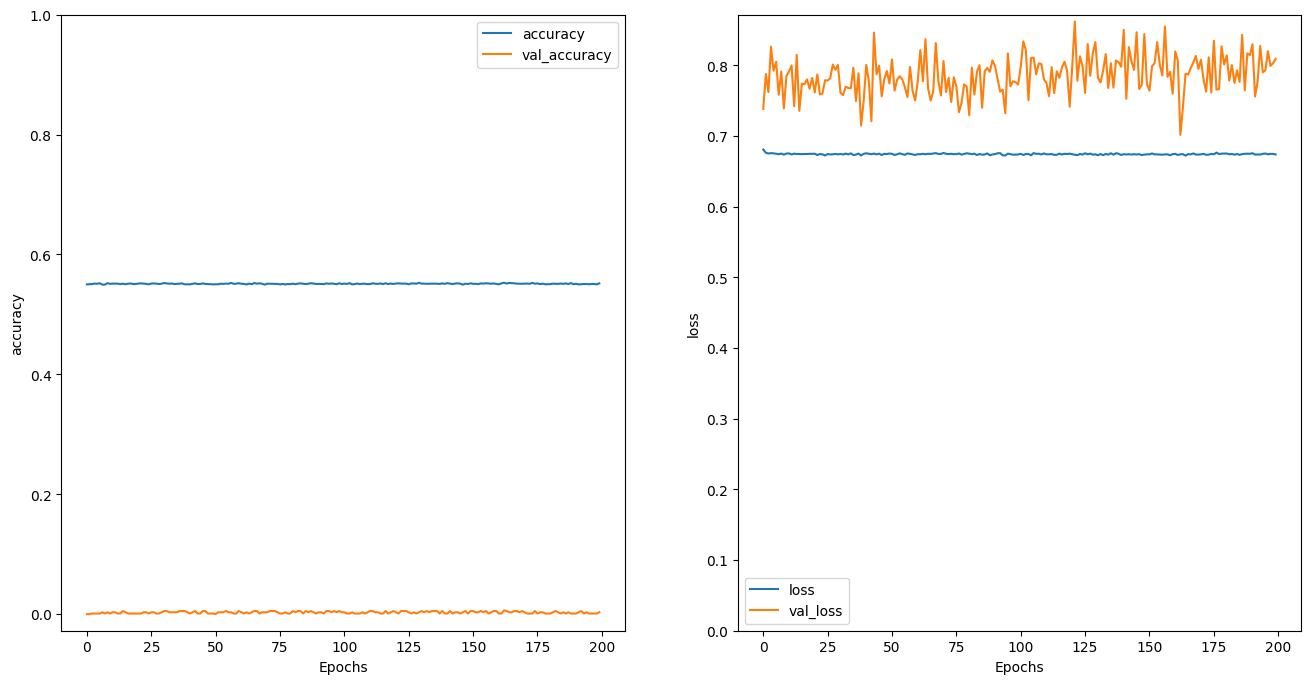

In [55]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [56]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 72ms/step
[-0.08274636]
